# Yelp_Data_Challenge - Restaurant Recommender

## Main Tasks

1. Clean data and get rating data
2. Select target users
3. Create utility matrix from records
    - 3.1 Option #1, use pandas.pivot_table
    - 3.2 Option #2, convert to sparse matrix using scipy.sparse.lil_matrix
4. Build restaurant recommender systems
    - 4.1 Popularity-based recommender
    - 4.2 Item-Item similarity recommender
    - 4.3 Matrix Factorization recommender: NMF
        - 4.3.1 Matrix Reconstruction error - NMF
        - 4.3.2 Recommendation - NMF
    - 4.4 Matrix Factorization recommender: UVD
        - 4.4.1 Matrix Reconstruction Error - UVD
        - 4.4.2 Recommendation - UVD
5. Specific recommendation results comparison and insights

In [78]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from time import time
import math
import matplotlib.pyplot as plt
% matplotlib inline

plt.style.use("ggplot")

In [48]:
df = pd.read_csv('dataset/last_2_years_restaurant_reviews.csv')

In [49]:
df.head()

,name,categories,avg_stars,cool,date,funny,review_id,stars,text,useful,user_id
0,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,2016-03-31,0,6SgvNWJltnZhW7duJgZ42w,5,This is mine and my fiancé's favorite steakhou...,0,oFyOUOeGTRZhFPF9uTqrTQ
1,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,2016-02-10,0,UxFpgng8dPMWOj99653k5Q,5,Truly Fantastic! Best Steak ever. Service was...,0,aVOGlN9fZ-BXcbtj6dbf0g
2,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,2017-02-14,0,Xp3ppynEvVu1KxDHQ3ae8w,5,Delmonico Steakhouse is a steakhouse owned by ...,0,KC8H7qTZVPIEnanw9fG43g
3,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,1,2017-05-28,0,LEzphAnz0vKE32PUCbjLgQ,4,One of the top steak places I've had in Vegas ...,2,3RTesI_MAwct13LWm4rhLw
4,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,2017-08-25,0,4e-cxYVdlIu2ZDxVJqUfOQ,5,This place is superb from the customer service...,0,EAOt1UQhJD0GG3l_jv7rWA


## 1. Clean data and get rating data 

#### Select relevant columns in the original dataframe

In [50]:
# Get business_id, user_id, stars for recommender

df_recommender = df[['name', 'user_id', 'stars']]
df_recommender.shape

(447033, 3)

In [51]:
# In total, 203744 users we have
print(len(df_recommender.user_id.unique()))

# In total, 3279 restaurants we have
print(len(df_recommender.name.unique()))

203744
3279


<BarContainer object of 5 artists>

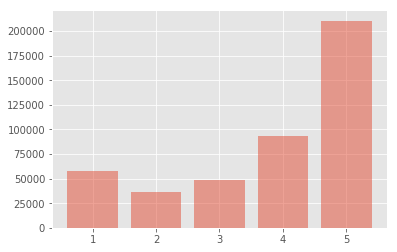

In [52]:
# Plot the star (rating) distribution using bar chart
plt.bar(df_recommender.stars.value_counts().index, 
        df_recommender.stars.value_counts().values, align='center', alpha=0.5)

#### Most of users rated 4 or 5 stars to restaurants 

## 2. Select target users

#### There are many users that haven't given many reviews, exclude these users from the item-item similarity recommender. My goal at here is to select those users who rated more than four times. Thus, the row dimension can be reduced.
#### We can recommend popular items at first to users given less than four reviews. 

In [53]:
# filter users commend more than 4 times

df_user = df_recommender['user_id'].value_counts()
df_user = df_user[df_user >= 3]

In [54]:
df_user.count(), df_user.sum()

(38576, 248913)

In [55]:
# filter users commend more than 4 times and set user_id as index
df_recommender_cleaned = df_recommender.set_index('user_id').ix[df_user.index].reset_index()
df_recommender_cleaned.head(2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,user_id,name,stars
0,bLbSNkLggFnqwNNzzq-Ijw,The Rice Shop,4
1,bLbSNkLggFnqwNNzzq-Ijw,Toddy Shop,5


In [56]:
df_recommender_cleaned.shape

(248913, 3)

##### extract the unique list of user_id and resturant_name 

In [57]:
user_id_list = pd.DataFrame(df_recommender_cleaned['user_id'].unique())
user_id_list = user_id_list.reset_index()
# Rename the columns 
user_id_list.columns = ['user_number', 'user_id']
user_id_list.head(2)

,user_number,user_id
0,0,bLbSNkLggFnqwNNzzq-Ijw
1,1,JaqcCU3nxReTW2cBLHounA


In [58]:
restaurant_list = pd.DataFrame(df_recommender_cleaned['name'].unique())
restaurant_list = restaurant_list.reset_index()
# Rename the columns 
restaurant_list.columns = ['restaurant_number', 'name']
restaurant_list.head(2)

,restaurant_number,name
0,0,The Rice Shop
1,1,Toddy Shop


In [59]:
# merge "df_recommender_cleaned", "user_id_list" and "restaurant_list"
df_recommender_cleaned = pd.merge(df_recommender_cleaned, user_id_list, on = 'user_id', how = 'left')
df_recommender_cleaned = pd.merge(df_recommender_cleaned, restaurant_list, on = 'name', how = 'left')

df_recommender_cleaned.head(2)

,user_id,name,stars,user_number,restaurant_number
0,bLbSNkLggFnqwNNzzq-Ijw,The Rice Shop,4,0,0
1,bLbSNkLggFnqwNNzzq-Ijw,Toddy Shop,5,0,1


## 3. Create utility matrix from records

### 3.1 Option #1, use pandas.pivot_table

In [60]:
utility_mat = pd.pivot_table(data = df_recommender_cleaned,
                           values = 'stars',
                           index = 'user_number',
                           columns = 'restaurant_number',
                           fill_value = 0)

In [61]:
utility_mat.head(2)

restaurant_number,0,1,2,3,4,5,6,7,8,9,...,3132,3133,3134,3135,3136,3137,3138,3139,3140,3141
user_number,,,,,,,,,,,,,,,,,,,,,
0,4,5,3,4,4.0,4,4.0,4.0,4,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0.0,3,0.0,0.0,3,4,...,0,0,0,0,0,0,0,0,0,0


In [62]:
utility_mat.shape

(38576, 3142)

### 3.2 Option #2, convert to sparse matrix using scipy.sparse.lil_matrix

In [63]:
highest_user_id = df_recommender_cleaned.user_number.max()
highest_restaurant_id = df_recommender_cleaned.restaurant_number.max()
ratings_mat = sparse.lil_matrix((highest_user_id + 1, highest_restaurant_id + 1))
ratings_mat

<38576x3142 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in LInked List format>

In [64]:
for _, row in df_recommender_cleaned.iterrows():
    ratings_mat[row.user_number, row.restaurant_number] = row.stars

In [65]:
ratings_mat

<38576x3142 sparse matrix of type '<class 'numpy.float64'>'
	with 247323 stored elements in LInked List format>

#### Let's carry on with option #2

In [66]:
utility_mat = ratings_mat

## 4. Build restaurant recommender systems
- 4.1 Popularity-based recommender
- 4.2 Item-Item similarity recommender
- 4.3 Matrix Factorization recommender: NMF
- 4.4 Matrix Factorization recommender: UVD

### 4.1 Popularity-based recommender

#### For every new user or user played less than five restaurants, we build a Popularity-based recommender to recommend most popular restaurants at first.
#### We define 'popular' as restaurants with most review records.

In [22]:
# count by restaurant_name and rank to find the mose popular restaurants
n = 10

# 'restaurant_id' for the n mostly played restaurants
Popularity_based_10_restaurant_name = df['name'].value_counts()[:n].index.tolist()
# corresponding 'restaurant_number' for n mostly played restaurants 'restaurant_id' 
Popularity_based_10 = []
for i in Popularity_based_10_restaurant_name:
    Popularity_based_10.append((restaurant_list[restaurant_list['name'] == i]['restaurant_number'].values)[0])

# for top 100 recommended restaurants
Popularity_based_100_restaurant_name = df['name'].value_counts()[:n].index.tolist()
# corresponding 'restaurant_number' for n mostly played restaurants 'restaurant_id' 
Popularity_based_100 = []
for i in Popularity_based_100_restaurant_name:
    Popularity_based_100.append((restaurant_list[restaurant_list['name'] == i]['restaurant_number'].values)[0])

In [23]:
print('Popularity-based recommender recommends top ' + str(n) +' restaurants:', '\n', str(Popularity_based_10))

Popularity-based recommender recommends top 10 restaurants: 
 [972, 920, 736, 51, 871, 718, 729, 921, 784, 651]


In [24]:
# print out the responding recommened restaurants names
print('top10 restaurants recommended by Popularity-based:')

for i in range(n):
    print(df['name'].value_counts()[i:i+1].index.tolist()[0])

top10 restaurants recommended by Popularity-based:
Hash House A Go Go
Bacchanal Buffet
Gangnam Asian BBQ Dining
Mon Ami Gabi
Shake Shack
Gordon Ramsay BurGR
Yardbird Southern Table & Bar
Tacos El Gordo
SkinnyFATS
Wicked Spoon


### 4.2 Item-Item similarity recommender

#### Let's reuse the ItemItemRecommender class derived from previous exercise

Hint: we need to make modification to accommodate the dense numpy array

#### Calculate item-item similarity matrix

In [67]:
# Item-Item Similarity Matrix
item_sim_mat = cosine_similarity(utility_mat.T)

#### Calculate neighborhood

In [68]:
least_to_most_sim_indexes = np.argsort(item_sim_mat, axis=1)

# Neighborhoods
neighborhood_size = 75
neighborhoods = least_to_most_sim_indexes[:, -neighborhood_size:]

In [69]:
neighborhoods.shape

(3142, 75)

#### Make rating prediction on a user

In [70]:
# Let's pick a lucky user
user_id = 100

In [71]:
n_users = utility_mat.shape[0]
n_items = utility_mat.shape[1]

start_time = time()
items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]
# Just initializing so we have somewhere to put rating preds
out = np.zeros(n_items)
for item_to_rate in range(n_items):
    relevant_items = np.intersect1d(neighborhoods[item_to_rate],
                                    items_rated_by_this_user,
                                    assume_unique=True)  # assume_unique speeds up intersection op
    out[item_to_rate] = ratings_mat[user_id, relevant_items] * \
        item_sim_mat[item_to_rate, relevant_items] / \
        item_sim_mat[item_to_rate, relevant_items].sum()


pred_ratings = np.nan_to_num(out)
print(pred_ratings)
print("Execution time: %f seconds" % (time()-start_time))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


[4.35953067 3.3596676  3.47323693 ... 0.         0.         0.        ]
Execution time: 1.230364 seconds


In [72]:
pred_ratings.shape

(3142,)

### Get final recommendations for a user

In [73]:
# Get item indexes sorted by predicted rating
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

# Find items that have been rated by user
items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]

# We want to exclude the items that have been rated by user
unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

# Recommend n restaurants
n = 10
Item_Item_10 = unrated_items_by_pred_rating[:n]
n = 100
Item_Item_100 = unrated_items_by_pred_rating[:n]

print('top10 restaurants recommended by Item-Item similarity recommender:', Item_Item_10)

top10 restaurants recommended by Item-Item similarity recommender: [1469, 421, 2350, 2102, 618, 551, 2429, 1874, 1653, 1988]


In [75]:
# print out the responding recommened restaurants names
print('top10 restaurants recommended by Item-Item similarity recommender:')

for i in unrated_items_by_pred_rating[:10]:
    print(restaurant_list.iloc[i, 1])

top10 restaurants recommended by Item-Item similarity recommender:
Oscar's Steakhouse
Burgerim
Triple Play American Grill
Wicked Slice
Satay Thai Bistro & Bar
Macayo's Mexican Restaurant
Gerardo's Tacos
Perú Chicken
Khun Chai Thai Restaurant
Citrus at the Downtown Grand Pool Deck


In [74]:
### check errors
# truth
ratings_true = ratings_mat[user_id, items_rated_by_this_user].todense()
# prediction
ratings_pred = pred_ratings[items_rated_by_this_user]
# print(list(zip(np.array(ratings_true).squeeze(),ratings_pred)))
err_one_user = ratings_true-ratings_pred
# print(err_one_user)
print("average_abs_err:", abs(err_one_user).mean())

average_abs_err: 0.34671037274181793


#### Next we will try Matrix Factorization approach to build recommender, because matrix factorization models always perform better than neighborhood models in collaborative filtering. The reason as below:

The reason is when we factorize a ‘m*n’ matrix into two ‘m*k’ and ‘k*n’ matrices we are reducing our "n"items to "k"factors, which means that instead than having our 3000 restaurants, we now have 500 factors where each factor is a linear combination of restaurants.  


The key is that recommending based on factors is more robust than just using movie similarities, maybe a user hasn’t played ‘stay’ but the user might have player other restaurants that are related to ‘stay’ via some latent factors and those can be used.  


The factors are called latent because they are there in our data but are not really discovered until we run the reduced rank matrix factorization, then the factors emerge and hence the "latency".  

### 4.3 Matrix Factorization recommender: NMF
- 4.3.1 Matrix Reconstruction error - NMF
- 4.3.2 Recommendation - NMF

In [76]:
from sklearn.decomposition import NMF

def fit_nmf(M,k):
    nmf = NMF(n_components=k)
    nmf.fit(M)
    W = nmf.transform(M);
    H = nmf.components_;
    err = nmf.reconstruction_err_
    return W,H,err

# decompose
W,H,err = fit_nmf(ratings_mat,700)
print(err)
print(W.shape,H.shape)

1069.0958942944771
(38576, 700) (700, 3142)


### 4.3.1 Matrix Reconstruction error - NMF
- MSE (Mean squared error)
- Average absolute error

In [79]:
# reconstruct
ratings_mat_fitted = W.dot(H)
errs = np.array((ratings_mat-ratings_mat_fitted).flatten()).squeeze()
mask = np.array((ratings_mat.todense()).flatten()).squeeze()>0

rmse = math.sqrt(np.mean(errs[mask]**2))
average_abs_err = abs(errs[mask]).mean()
print("RMSE: ", rmse)
print("average_abs_err: ", average_abs_err)

RMSE:  2.084815335930057
average_abs_err:  1.1284501711048098


#### The RMSE of NMF is 2.0848, and the average absolute error is 1.1285, the performance is acceptable.
#### Next we will try to get recommendations for a user: user_number = 100

### 4.3.2 Recommendation - NMF

In [80]:
# get recommendations for one user
user_id = 100
n = 10

pred_ratings = ratings_mat_fitted[user_id,:]
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]

unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

# Recommend n restaurants
n = 10
NMF_10 = unrated_items_by_pred_rating[:n]
n = 100
NMF_100 = unrated_items_by_pred_rating[:n]

print('top10 restaurants recommended by NMF recommender:', NMF_10)

top10 restaurants recommended by NMF recommender: [168, 1463, 361, 1892, 1208, 1629, 940, 1500, 2108, 227]


In [81]:
# print out the responding recommened restaurants names
print('top10 restaurants recommended by NMF recommender:')

for i in unrated_items_by_pred_rating[:10]:
    print(restaurant_list.iloc[i, 1])

top10 restaurants recommended by NMF recommender:
Fuzzy's Taco Shop
LOL Kids Club
Cafe Sanuki
ZiKiZ
Fiesta Filipina Cuisine
Rosati's
Jenni Pho
Siamese Bistro
Benjarong Authentic Thai Cuisine
Bowl Tique Avenue


In [82]:
### check errors
# truth
ratings_true = ratings_mat[user_id, items_rated_by_this_user].todense()
# prediction
ratings_pred = pred_ratings[items_rated_by_this_user]
# print(list(zip(np.array(ratings_true).squeeze(),ratings_pred)))
err_one_user = ratings_true-ratings_pred
# print(err_one_user)
print(abs(err_one_user).mean())

0.6795087029675263


#### The result is slightly different from what we discussed above, the average absolute error of NMF is 0.6795 for this specific user is slightly worse than 0.3467 of Item-Item similarity recommender, perhaps because the size of our dataset with 3000+ restaurants is too small to show the advantage of NMF.
#### Next we will try UVD to verify whether it performs better than NMF.

### 4.4 Matrix Factorization recommender: UVD
- 4.4.1 Matrix Reconstruction Error - UVD
- 4.4.2 Recommendation - UVD

In [83]:
from sklearn.decomposition import TruncatedSVD

def fit_uvd(M,k):
    # use TruncatedSVD to realize UVD
    svd = TruncatedSVD(n_components=k, n_iter=7, random_state=0)
    svd.fit(M)

    V = svd.components_
    U = svd.transform(M) # effectively, it's doing: U = M.dot(V.T)
    # we can ignore svd.singular_values_ for our purpose
    
    return U,V, svd

# decompose
U,V,svd = fit_uvd(ratings_mat,700)

In [84]:
print(U.shape,V.shape)

(38576, 700) (700, 3142)


### 4.4.1 Matrix Reconstruction Error - UVD

In [85]:
# reconstruct
ratings_mat_fitted = U.dot(V) # U*V

# recall: U = M.dot(V.T), then this is M.dot(V.T).dot(V)
# original M is transformed to new space, then transformed back
# this is another way to understand it!

# calculate errs
errs = np.array((ratings_mat-ratings_mat_fitted).flatten()).squeeze()
mask = np.array((ratings_mat.todense()).flatten()).squeeze()>0

rmse = math.sqrt(np.mean(errs[mask]**2))
average_abs_err = abs(errs[mask]).mean()
print("RMSE: ", rmse)
print("average_abs_err: ", average_abs_err)

RMSE:  1.873302782318676
average_abs_err:  1.0795355987540387


#### The RMSE of UVD is 1.8733 and the average absolute error is 1.0795, which are better than scores of NMF(2.0848 and 1.1285). 
#### UVD performs better because it has larger degree of freedom than NMF, to be specific, NMF is a specialization of UVD, all values of V, W, and H in NMF must be non-negative.
#### Next we will try to get recommendations for a user: user_number = 100

### 4.4.2 Recommendation - UVD

In [86]:
# get recommendations for one user
user_id = 100

pred_ratings = ratings_mat_fitted[user_id,:]
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]

unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

# Recommend n restaurants
n = 10
UVD_10 = unrated_items_by_pred_rating[:n]
n = 100
UVD_100 = unrated_items_by_pred_rating[:n]

print('top10 restaurants recommended by UVD recommender:', UVD_10)

top10 restaurants recommended by UVD recommender: [933, 599, 1083, 1752, 673, 2108, 1154, 1629, 1891, 374]


In [87]:
# print out the responding recommened restaurants names
print('top10 restaurants recommended by UVD recommender:')

for i in unrated_items_by_pred_rating[:10]:
    print(restaurant_list.iloc[i, 1])

top10 restaurants recommended by UVD recommender:
Swish Shabu Shabu
Kyara Japanese Tapas
Tea Station
Little Caesars Pizza
TangTangTang
Benjarong Authentic Thai Cuisine
808 Sushi
Rosati's
Pineapple Park
Cheeburger Cheeburger Express


In [88]:
### check errors
# truth
ratings_true = ratings_mat[user_id, items_rated_by_this_user].todense()
# prediction
ratings_pred = pred_ratings[items_rated_by_this_user]
# print(list(zip(np.array(ratings_true).squeeze(),ratings_pred)))
err_one_user = ratings_true-ratings_pred
# print(err_one_user)
print(abs(err_one_user).mean())

0.5461330854070534


#### With an average absolute error of 0.5461, which is slightly better than 0.6795 of NMF.

## 5 Specific recommendation results comparison and insights

#### Next we compare the recommendation results for 'user with user_number = 100' generated by the four models above. We generate the overlap tabel of the top_10 results given by the four models for 'user with user_number = 100'

In [89]:
top10_overlap = pd.DataFrame([len(np.intersect1d(Popularity_based_10, Item_Item_10)),
                                   len(np.intersect1d(Popularity_based_10, UVD_10)),
                                   len(np.intersect1d(Popularity_based_10, NMF_10)),
                                   len(np.intersect1d(Item_Item_10, NMF_10)),
                                   len(np.intersect1d(Item_Item_10, UVD_10)),
                                   len(np.intersect1d(NMF_10, UVD_10)),
                                   len(np.intersect1d(np.intersect1d(np.intersect1d(Popularity_based_10, Item_Item_10), NMF_10), UVD_10))],
                                 index = ['Popularity-based_with_Item-Item',
                                           'Popularity-based_with_NMF',
                                           'Popularity-based_with_UVD',
                                           'Item-Item_with_NMF',
                                           'Item-Item_with_UVD',
                                           'NMF_with_UVD',
                                           'Popularity-based_with_Item-Item_with_NMF_with_UVD'],
                                 columns = ['number_of_same_recommended_restaurants_in_10'])
print('The overlap of the top 10 recommendation generated by these four models') 
top10_overlap

The overlap of the top 10 recommendation generated by these four models


,number_of_same_recommended_restaurants_in_10
Popularity-based_with_Item-Item,0
Popularity-based_with_NMF,0
Popularity-based_with_UVD,0
Item-Item_with_NMF,0
Item-Item_with_UVD,0
NMF_with_UVD,2
Popularity-based_with_Item-Item_with_NMF_with_UVD,0


#### We generate the overlap tabel of the top_100 results given by the four models for 'user with user_number = 100'

In [90]:
top100_overlap = pd.DataFrame([len(np.intersect1d(Popularity_based_100, Item_Item_100)),
                                   len(np.intersect1d(Popularity_based_100, UVD_100)),
                                   len(np.intersect1d(Popularity_based_100, NMF_100)),
                                   len(np.intersect1d(Item_Item_100, NMF_100)),
                                   len(np.intersect1d(Item_Item_100, UVD_100)),
                                   len(np.intersect1d(NMF_100, UVD_100)),
                                   len(np.intersect1d(np.intersect1d(np.intersect1d(Popularity_based_100, Item_Item_100), NMF_100), UVD_100))],
                                 index = ['Popularity-based_with_Item-Item',
                                           'Popularity-based_with_NMF',
                                           'Popularity-based_with_UVD',
                                           'Item-Item_with_NMF',
                                           'Item-Item_with_UVD',
                                           'NMF_with_UVD',
                                           'Popularity-based_with_Item-Item_with_NMF_with_UVD'],
                                 columns = ['number_of_same_recommended_restaurants_in_100'])
print('The overlap of the top 100 recommendation generated by these four models') 
top100_overlap

The overlap of the top 100 recommendation generated by these four models


,number_of_same_recommended_restaurants_in_100
Popularity-based_with_Item-Item,0
Popularity-based_with_NMF,0
Popularity-based_with_UVD,0
Item-Item_with_NMF,2
Item-Item_with_UVD,2
NMF_with_UVD,40
Popularity-based_with_Item-Item_with_NMF_with_UVD,0


### From the intersets tables above, we notice that: 

1. The recommended songs given by Popularity-based, Neighborhood-based approach and Matrix Factorization approach models are very different from each other, have no overlap in top 10 and only 2 in top 100 recommended songs.  

2. While the recommended songs given by NMF and TruncatedSVD have 2 overlaps in top 10 and 40 overlaps in top 100 recommended songs.  

### Conlcusion:

1. For new user or user reviewed less than three restaurants, we can recommend most popular restaurants at first generated by our Popularity-based recommender.  

2. For user reviewed more than three restaurants:  
2.1 Given the performances of NMF and UVD are comparable, we can have the overlap of commendation results generated by these two models as the final recommendation.  
2.2 As the results generated by Popularity-based, Neighborhood-based Approach and Matrix Factorization Approach models are totally different, we can allocate different weights to these models to construct the final recommendation.   
Like 0.2 for Popularity-based, 0.2 for Neighborhood-based, 0.6 for overlap of NMF and UVD.   